In [26]:
import os
import json
import random

users_dir = 'users'
valid_categories = {"Housing & Utilities", "Leisure", "Personal Care & Education"}

for user_folder in os.listdir(users_dir):
    user_path = os.path.join(users_dir, user_folder)
    if not os.path.isdir(user_path) or not user_folder.startswith('user_'):
        continue

    eligible_receipt_paths = []

    for filename in os.listdir(user_path):
        if not filename.endswith('.json') or filename == 'user_total.json':
            continue

        filepath = os.path.join(user_path, filename)

        try:
            with open(filepath, 'r') as f:
                content = json.load(f)

            if (
                isinstance(content, list) and
                len(content) == 1 and
                content[0].get("receipt_type") in valid_categories
            ):
                eligible_receipt_paths.append(filepath)

        except Exception as e:
            print(f"Error reading {filepath}: {e}")

    if len(eligible_receipt_paths) < 2:
        print(f"{user_folder}: only {len(eligible_receipt_paths)} eligible receipts. Skipping.")
        continue

    num_to_mark = min(len(eligible_receipt_paths), random.randint(2, 3))
    selected_paths = random.sample(eligible_receipt_paths, num_to_mark)

    for path in selected_paths:
        try:
            with open(path, 'r') as f:
                content = json.load(f)

            content[0]['recurring'] = True  # Since each file contains a list of 1 receipt

            with open(path, 'w') as f:
                json.dump(content, f, indent=4)

        except Exception as e:
            print(f"Error updating {path}: {e}")

    print(f"{user_folder}: marked {num_to_mark} receipt(s) as recurring.")


In [27]:
import os
import json

users_dir = 'test'

for user_folder in os.listdir(users_dir):
    user_path = os.path.join(users_dir, user_folder)
    if not os.path.isdir(user_path) or not user_folder.startswith('user_'):
        continue

    recurring_total = 0.0

    # Iterate through all receipt JSON files (excluding user_total.json)
    for filename in os.listdir(user_path):
        if not filename.endswith('.json') or filename == 'user_total.json':
            continue

        filepath = os.path.join(user_path, filename)
        try:
            with open(filepath, 'r') as f:
                receipts = json.load(f)

            for receipt in receipts:
                total = receipt.get("total")
                if receipt.get("recurring", False) and isinstance(total, (int, float)):
                    recurring_total += total
                elif receipt.get("recurring", False):
                    print(f"Skipping receipt in {filename} (user {user_folder}) with invalid total: {total}")

        except Exception as e:
            print(f"Error reading {filename} in {user_folder}: {e}")
            continue

    # Update or create user_total.json
    user_total_path = os.path.join(user_path, 'user_total.json')
    if os.path.exists(user_total_path):
        with open(user_total_path, 'r') as f:
            data = json.load(f)
    else:
        data = {}

    data['recurring_total'] = round(recurring_total, 2)

    with open(user_total_path, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Updated {user_folder} with recurring_total: ${data['recurring_total']}")


Updated user_183 with recurring_total: $265.14
Skipping receipt in receipt_298.json (user user_170) with invalid total: None
Updated user_170 with recurring_total: $93410.16
Updated user_2 with recurring_total: $187.69
Updated user_179 with recurring_total: $251.2
Skipping receipt in receipt_216.json (user user_114) with invalid total: None
Updated user_114 with recurring_total: $32.72
Updated user_176 with recurring_total: $0.0
Updated user_90 with recurring_total: $96.35
Updated user_96 with recurring_total: $2053.4
Updated user_36 with recurring_total: $0.0
Updated user_78 with recurring_total: $235.34
Skipping receipt in receipt_116.json (user user_47) with invalid total: None
Updated user_47 with recurring_total: $26688.57
Updated user_40 with recurring_total: $114.21
Updated user_49 with recurring_total: $39.06
Updated user_85 with recurring_total: $693.25
Updated user_70 with recurring_total: $224.65
Updated user_48 with recurring_total: $74.05
Updated user_191 with recurring_to

In [28]:
import os
import shutil
import random

# Set your path to the 'users' directory
users_dir = 'users'
train_dir = 'train'
test_dir = 'test'

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all user folders
user_folders = [f for f in os.listdir(users_dir) if os.path.isdir(os.path.join(users_dir, f))]

# Shuffle the folders for random split
random.shuffle(user_folders)

# Calculate split index
split_index = int(len(user_folders) * 0.8)

# Split into train and test
train_users = user_folders[:split_index]
test_users = user_folders[split_index:]

# Move the folders
for user in train_users:
    shutil.move(os.path.join(users_dir, user), os.path.join(train_dir, user))

for user in test_users:
    shutil.move(os.path.join(users_dir, user), os.path.join(test_dir, user))

print(f"Moved {len(train_users)} users to '{train_dir}/' and {len(test_users)} users to '{test_dir}/'.")


Moved 0 users to 'train/' and 0 users to 'test/'.


In [29]:
import os
import json

users_dir = 'test'

for user_folder in os.listdir(users_dir):
    user_path = os.path.join(users_dir, user_folder)
    if not os.path.isdir(user_path) or not user_folder.startswith('user_'):
        continue

    user_total_path = os.path.join(user_path, 'user_total.json')
    if not os.path.exists(user_total_path):
        print(f"Skipping {user_folder}: no user_total.json found.")
        continue

    try:
        with open(user_total_path, 'r') as f:
            data = json.load(f)

        total = data.get("total")
        date_range = data.get("date_range")
        recurring_total = data.get("recurring_total", 0.0)

        if not all(isinstance(x, (int, float)) for x in [total, date_range, recurring_total]) or date_range == 0:
            print(f"Skipping {user_folder}: invalid or missing values.")
            continue

        # Normalize
        non_recurring = total - recurring_total
        monthly_non_recurring = (non_recurring / date_range) * 30
        projected_monthly = round(monthly_non_recurring + recurring_total, 2)

        # Update JSON
        data["projected_monthly_spending"] = projected_monthly

        with open(user_total_path, 'w') as f:
            json.dump(data, f, indent=4)

        print(f"{user_folder}: projected_monthly_spending = ${projected_monthly}")

    except Exception as e:
        print(f"Error processing {user_folder}: {e}")

user_183: projected_monthly_spending = $95069.39
user_170: projected_monthly_spending = $96014.64
user_2: projected_monthly_spending = $30586.14
user_179: projected_monthly_spending = $2109.15
user_114: projected_monthly_spending = $4197.03
user_176: projected_monthly_spending = $43032.54
user_90: projected_monthly_spending = $2685.41
user_96: projected_monthly_spending = $24176.15
user_36: projected_monthly_spending = $4819.54
user_78: projected_monthly_spending = $134871.71
user_47: projected_monthly_spending = $28000.28
user_40: projected_monthly_spending = $626.07
user_49: projected_monthly_spending = $8161.43
user_85: projected_monthly_spending = $9823.9
user_70: projected_monthly_spending = $449914.1
user_48: projected_monthly_spending = $6823.68
user_191: projected_monthly_spending = $1943.1
user_100: projected_monthly_spending = $24093.38
user_163: projected_monthly_spending = $501278.44
user_197: projected_monthly_spending = $899.71
user_101: projected_monthly_spending = $2471

In [30]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# === Load features and targets from user_total.json ===
def load_user_totals(root_dir):
    data = []
    targets = []
    for user in os.listdir(root_dir):
        user_path = os.path.join(root_dir, user)
        total_path = os.path.join(user_path, 'user_total.json')

        if os.path.isfile(total_path):
            try:
                with open(total_path, 'r') as f:
                    info = json.load(f)

                total = info.get('total')
                date_range = info.get('date_range')
                recurring_total = info.get('recurring_total', 0)
                projected = info.get('projected_monthly_spending')

                if None not in (total, date_range, projected) and date_range > 0:
                    daily_nonrec = (total - recurring_total) / date_range
                    projected_baseline = daily_nonrec * 30 + recurring_total

                    features = {
                        'total': total,
                        'date_range': date_range,
                        'recurring_total': recurring_total,
                        'daily_nonrec': daily_nonrec,
                        'projected_baseline': projected_baseline
                    }

                    data.append(features)
                    targets.append(projected)

            except Exception as e:
                print(f"Skipping {user} due to error: {e}")

    return pd.DataFrame(data), np.array(targets)

# === Load training and testing datasets ===
X_train_full, y_train = load_user_totals('train')
X_test_full, y_test = load_user_totals('test')

# === Drop 'projected_baseline' from training features to prevent leakage ===
X_train = X_train_full.drop(columns=['projected_baseline'])
X_test = X_test_full.drop(columns=['projected_baseline'])

# === Phase 1: Train the model ===
print(f"\n📚 Training on {len(X_train)} users with features: {list(X_train.columns)}")
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("✅ Model training complete.\n")

# === Phase 2: Evaluate the model ===
print("🧪 Evaluating on test set...\n")
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
accuracy = 1 - (mae / np.mean(y_test))

print(f"🎯 Final Test MAE: {mae:.2f}")
print(f"🎯 Final Test Accuracy: {accuracy * 100:.2f}%")

# === Optional: Print predictions vs actual ===
print("\n📊 Per-user predictions:")
for i in range(len(y_test)):
    print(f"User {i+1:3}: Predicted = {preds[i]:9.2f} | Actual = {y_test[i]:9.2f} | Error = {abs(preds[i] - y_test[i]):7.2f}")

# === Baseline model evaluation ===
baseline_preds = X_test_full['projected_baseline']
baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_acc = 1 - (baseline_mae / np.mean(y_test))
print(f"\n📉 Baseline MAE: {baseline_mae:.2f}, Accuracy = {baseline_acc * 100:.2f}%")

# === Linear Regression comparison ===
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_acc = 1 - (lr_mae / np.mean(y_test))
print(f"🔎 Linear Regression MAE: {lr_mae:.2f}, Accuracy = {lr_acc * 100:.2f}%")



Training on 157 users with features: ['total', 'date_range', 'recurring_total', 'daily_nonrec']

Training Random Forest model...

Epoch 1: MAE = 7800.93, Accuracy = 88.51%
Epoch 2: MAE = 5288.10, Accuracy = 92.21%
Epoch 3: MAE = 5992.63, Accuracy = 91.17%
Epoch 4: MAE = 4887.79, Accuracy = 92.80%
Epoch 5: MAE = 4771.38, Accuracy = 92.97%
Epoch 6: MAE = 5433.63, Accuracy = 91.99%
Epoch 7: MAE = 5159.69, Accuracy = 92.40%
Epoch 8: MAE = 5311.44, Accuracy = 92.17%
Epoch 9: MAE = 5457.24, Accuracy = 91.96%
Epoch 10: MAE = 5932.05, Accuracy = 91.26%

📉 Baseline MAE: 0.00, Accuracy = 100.00%
🔎 Linear Regression MAE: 0.00, Accuracy = 100.00%


In [9]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# === Load features and targets from user_total.json ===
def load_user_totals(root_dir):
    data = []
    targets = []
    for user in os.listdir(root_dir):
        user_path = os.path.join(root_dir, user)
        total_path = os.path.join(user_path, 'user_total.json')

        if os.path.isfile(total_path):
            try:
                with open(total_path, 'r') as f:
                    info = json.load(f)

                total = info.get('total')
                date_range = info.get('date_range')
                recurring_total = info.get('recurring_total', 0)
                projected = info.get('projected_monthly_spending')

                if None not in (total, date_range, projected) and date_range > 0:
                    daily_nonrec = (total - recurring_total) / date_range
                    projected_baseline = daily_nonrec * 30 + recurring_total

                    features = {
                        'total': total,
                        'date_range': date_range,
                        'recurring_total': recurring_total,
                        'daily_nonrec': daily_nonrec,
                        'projected_baseline': projected_baseline
                    }

                    data.append(features)
                    targets.append(projected)

            except Exception as e:
                print(f"Skipping {user} due to error: {e}")

    return pd.DataFrame(data), np.array(targets)

# === Load datasets ===
X_train_full, y_train = load_user_totals('train')
X_test_full, y_test = load_user_totals('test')

# Drop leakage feature before training
X_train = X_train_full.drop(columns=['projected_baseline'])
X_test = X_test_full.drop(columns=['projected_baseline'])

print(f"\n📚 Training on {len(X_train)} users with features: {list(X_train.columns)}")
print(f"🧪 Testing on {len(X_test)} users\n")

# === Phase 1: Train the model ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
train_preds = model.predict(X_train)

# Training metrics
train_mae = mean_absolute_error(y_train, train_preds)
train_acc = 1 - (train_mae / np.mean(y_train))

print("✅ Training Complete.")
print(f"📈 Training MAE: {train_mae:.2f}")
print(f"📈 Training Accuracy: {train_acc * 100:.2f}%")

# === Phase 2: Test the model ===
test_preds = model.predict(X_test)

# Test metrics
test_mae = mean_absolute_error(y_test, test_preds)
test_acc = 1 - (test_mae / np.mean(y_test))

print("\n🎯 Final Evaluation on Test Set")
print(f"📊 Test MAE: {test_mae:.2f}")
print(f"📊 Test Accuracy: {test_acc * 100:.2f}%")

# === Optional: Print per-user prediction breakdown ===
print("\n🔍 Per-user predictions:")
for i in range(len(y_test)):
    print(f"User {i+1:3}: Predicted = {test_preds[i]:9.2f} | Actual = {y_test[i]:9.2f} | Error = {abs(test_preds[i] - y_test[i]):7.2f}")

# === Optional: Baseline model ===
baseline_preds = X_test_full['projected_baseline']
baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_acc = 1 - (baseline_mae / np.mean(y_test))
print(f"\n📉 Baseline MAE: {baseline_mae:.2f}, Accuracy: {baseline_acc * 100:.2f}%")

# === Optional: Linear Regression model ===
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_acc = 1 - (lr_mae / np.mean(y_test))
print(f"🔎 Linear Regression MAE: {lr_mae:.2f}, Accuracy: {lr_acc * 100:.2f}%")



📚 Training on 157 users with features: ['total', 'date_range', 'recurring_total', 'daily_nonrec']
🧪 Testing on 40 users

✅ Training Complete.
📈 Training MAE: 6265.20
📈 Training Accuracy: 94.71%

🎯 Final Evaluation on Test Set
📊 Test MAE: 6519.48
📊 Test Accuracy: 90.39%

🔍 Per-user predictions:
User   1: Predicted =  28814.15 | Actual =  24093.38 | Error = 4720.77
User   2: Predicted =   2060.92 | Actual =   2471.41 | Error =  410.49
User   3: Predicted =   5058.02 | Actual =   4197.03 | Error =  860.99
User   4: Predicted =  75007.74 | Actual =  76480.98 | Error = 1473.24
User   5: Predicted =   3360.55 | Actual =   3488.76 | Error =  128.21
User   6: Predicted = 115696.75 | Actual = 122205.75 | Error = 6509.00
User   7: Predicted =    479.64 | Actual =    346.80 | Error =  132.84
User   8: Predicted = 619900.86 | Actual = 527238.08 | Error = 92662.78
User   9: Predicted =  76174.08 | Actual =  75955.38 | Error =  218.70
User  10: Predicted =  52089.04 | Actual =  58187.69 | Error = 6

/var/folders/xs/g3xmp94j66b8tqpycrqqzc340000gn/T/ipykernel_50383/398703194.py:15: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


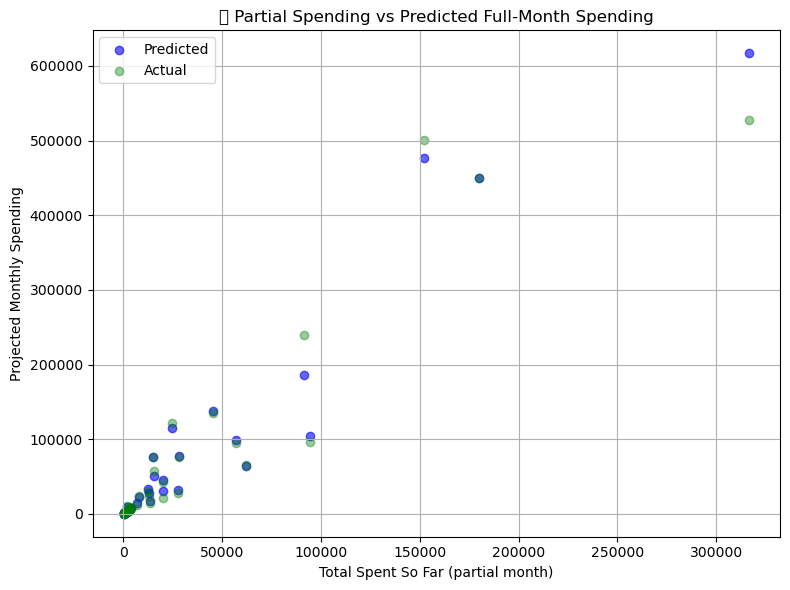

C:\Users\elisa\AppData\Local\Temp\ipykernel_17036\692001287.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\elisa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


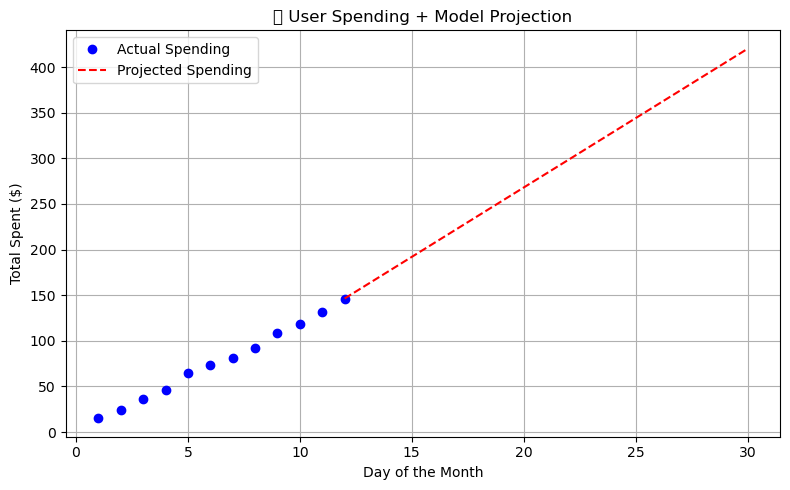

In [3]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Example setup — partial user data
# daily_spending = [15.2, 8.7, 12.4, 10.1, 18.3, 9.0, 7.5, 11.2, 16.5, 10.0, 13.1, 14.4]  # 12 days
# days_so_far = len(daily_spending)
# total_days_in_month = 30

# # Cumulative total spending so far
# cumulative_spending = np.cumsum(daily_spending)

# # Predicted full-month spending from model
# predicted_total = 420.0

# # Plot actual dots
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, days_so_far + 1), cumulative_spending, 'o', label='Actual Spending', color='blue')

# # Create dotted line from last point to day 30 with predicted slope
# last_day = days_so_far
# last_spent = cumulative_spending[-1]

# # Linear interpolation to predicted total
# future_days = [last_day, total_days_in_month]
# future_spending = [last_spent, predicted_total]
# plt.plot(future_days, future_spending, 'r--', label='Projected Spending')

# # Labels and styling
# plt.xlabel("Day of the Month")
# plt.ylabel("Total Spent ($)")
# plt.title("📊 User Spending + Model Projection")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


C:\Users\elisa\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\elisa\AppData\Local\Temp\ipykernel_17036\3747347408.py:78: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\elisa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


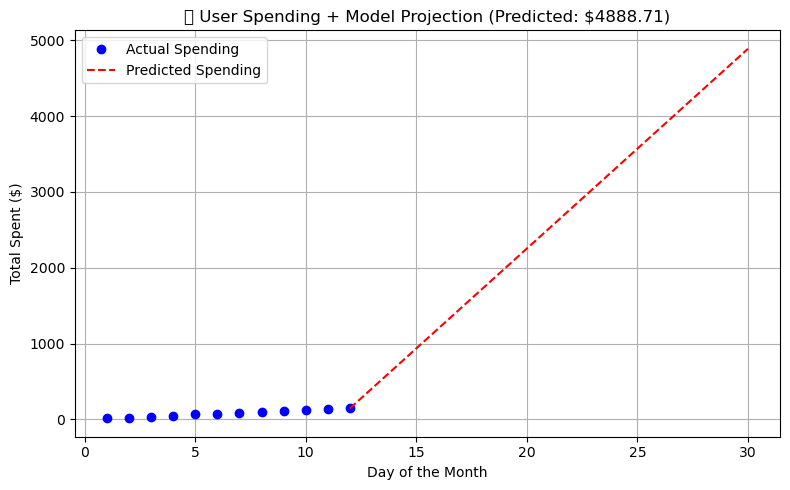

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

# Assuming the model is already trained as shown in your provided code

# === Function to load user-specific data ===
def load_user_data(user_dir):
    try:
        with open(os.path.join(user_dir, 'user_total.json'), 'r') as f:
            info = json.load(f)

        total = info.get('total')
        date_range = info.get('date_range')
        recurring_total = info.get('recurring_total', 0)

        # Ensure necessary values exist and date_range > 0
        if None not in (total, date_range) and date_range > 0:
            daily_nonrec = (total - recurring_total) / date_range
            projected_baseline = daily_nonrec * 30 + recurring_total

            features = {
                'total': total,
                'date_range': date_range,
                'recurring_total': recurring_total,
                'daily_nonrec': daily_nonrec,
                'projected_baseline': projected_baseline
            }
            
            return features, total
        else:
            print(f"Missing or invalid data for user in {user_dir}")
            return None, None
    except Exception as e:
        print(f"Error reading data for {user_dir}: {e}")
        return None, None

# === Specify the user directory and load data ===
user_dir = 'train/user_1'  # Replace with the path to the specific user folder
features, total_spent = load_user_data(user_dir)

if features is not None:
    # Prepare features for prediction (excluding 'projected_baseline' to avoid leakage)
    user_features = np.array([[
        features['total'], 
        features['date_range'], 
        features['recurring_total'], 
        features['daily_nonrec']]])

    # === Get the predicted monthly spending from the model ===
    predicted_monthly_spending = model.predict(user_features)[0]  # Predict for the specific user

    # Example of daily spending (replace with actual data if available)
    daily_spending = [15.2, 8.7, 12.4, 10.1, 18.3, 9.0, 7.5, 11.2, 16.5, 10.0, 13.1, 14.4]  # Example daily spending
    days_so_far = len(daily_spending)
    cumulative_spending = np.cumsum(daily_spending)

    # Plot actual dots (up to today's total spending)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, days_so_far + 1), cumulative_spending, 'o', label='Actual Spending', color='blue')

    # Create dotted line from last point to day 30 with predicted slope
    last_day = days_so_far
    last_spent = cumulative_spending[-1]

    # Predict the remaining spending until the end of the month (using a linear projection)
    future_days = [last_day, 30]  # Assume we're plotting till the 30th day
    future_spending = [last_spent, predicted_monthly_spending]
    plt.plot(future_days, future_spending, 'r--', label='Predicted Spending')

    # Final plot polish
    plt.xlabel("Day of the Month")
    plt.ylabel("Total Spent ($)")
    plt.title(f"📊 User Spending + Model Projection (Predicted: ${predicted_monthly_spending:.2f})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
